<h1>Lab : simplified JPEG encoder/decoder</h1>

# VERY IMPORTANT: Take time to read the guidance before coding.

**Read the guidance**

**Read the topic (.pdf file) first**

**Functions to be implemented:**
  - rlencode (in Section 1)
  - count_symbols (in Section 1)
  - and also the 'main' functions (in Section 3)

**Some given functions:** (in Section 2)
  - zigzag
  - functions related to Huffman coding, such as ``construct_huffman_table, encode_huffman, decode_huffman``

**Some useful functions:**
  - imshow()
  - img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)
  - cv2.dct

# **You can directly go to Section 3 and code there**

**Import the libs**

In [28]:
import numpy as np
import requests
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Any, Dict, Optional

import cv2

def show(img:np.ndarray):
    im = Image.fromarray(img)
    print(im.size, im.mode, im.format, img.min(),  img.max())
    display(im)

def load_from_url(url: str) -> np.ndarray:
    return np.asarray(Image.open(requests.get(url, stream=True).raw))

def debug_ndarray(arr:np.ndarray, name:str='') -> None:
    print(name, arr.shape, arr.dtype, arr.min(), arr.max())

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img)
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

# 1. Functions to be implemented

*   rlencode: Run length coding
*   count_symbols: this will be used for Huffman coding
*   zigzag: Implementing this function is optional, as there is a relatively simple 'manual' method available for accomplishing the task (see the begining of Section 3)
# *   **Note: however, you dont need to implement these functions immediately. You can go to Section 3 to implement different first steps of JPEG: block devivision, centering, DCT, quantification.**





In [52]:
def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    computes the zigzag of a quantized block
    :param numpy.ndarray matrix: quantized matrix
    :returns: zigzag vectors in an array
    """
    # initializing the variables
    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = matrix.shape[0]
    h_max = matrix.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = matrix[v, h]  # first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # last column
                output[i] = matrix[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = matrix[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                output[i] = matrix[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # first column
                output[i] = matrix[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = matrix[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = matrix[v, h]
            break
    return output


def rlencode(data:list, symbol:int=0, escape=257) -> np.ndarray:
    '''
    Encode a list of values using run length encoding
    when `symbol` is encountered,
    the next value is `escape` followed by the number of `symbol`.
    '''
    out = []
    count=0
    ###
    #TODO
    for i in range(len(data)):
        if data[i]==symbol:
            count+=1
        else:
            if count>0:
                out.append(escape)
                out.append(count)
                count=0
            out.append(data[i])
    if count>0:
        out.append(escape)
        out.append(count)
    ###
    return np.array(out)

def count_symbols(data:list) -> Dict[Any, int]:
    '''
    Compute the frequency of each value in the list
    '''
    freq = {}
    ###
    #TODO
    for value in data:
        if value in freq:
            freq[value]+=1
        else:
            freq[value]=1
    ###
    return freq


#testing
freq = count_symbols([0, 0, 0, 0, 1, 1, 1, 2, 2, 3])
print(freq)
#'output: {0: 4, 1: 3, 2: 2, 3: 1}'


{0: 4, 1: 3, 2: 2, 3: 1}


#2. Given functions

**Huffman tree**

To obtain the Huffman code, it is necessary to construct a (binary) Huffman tree.
This tree is constructed from a list of leaves (symbols) and internal nodes (sum of the weights of the children).
Each node is associated with a value which is the sum of the values of its children.
The leaves correspond to symbols and are associated with their number of occurrences in the vector.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/1200px-Huffman_tree_2.svg.png" width=500>

Huffman encoding involves counting the number of occurrences of each character in a sentence and representing each character as a leaf node on a tree with a weight equal to its occurrence count. The tree is constructed by combining the two nodes with the lowest weights at each step until only one node, the root of the tree, remains.

In [61]:
def compute_huffman_tree(data:list, freq:Optional[dict]=None) -> Tuple[int, Any, Any]:
    '''
    Compute a huffman tree from a frequency table of values
    Return the root node of the tree
    '''
    if freq is None:
        freq: Dict[Any, int] = count_symbols(data)

    # create a list of nodes
    nodes = []
    for symbol, freq in freq.items():
        nodes.append((freq, symbol))

    # sort the list of nodes by count
    nodes.sort(key=lambda x: x[0])

    # create a tree
    while len(nodes) > 1:
        # get the two lowest frequency nodes
        left, right = nodes[:2]

        # create a new node with the sum of the frequencies
        new_node_count = left[0] + right[0]
        new_node = (new_node_count, left, right)
        # remove the two lowest frequency nodes
        nodes = nodes[2:]
        # insert the new node
        nodes.append(new_node)
        # sort the nodes by frequency
        nodes.sort(key=lambda x: x[0])

    # return the root node
    return nodes[0]

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
from pprint import pprint

data_tree = compute_huffman_tree(data)
pprint(data_tree)

(36,
 (16,
  (8, (4, 'a'), (4, 'e')),
  (8, (4, (2, 't'), (2, 'h')), (4, (2, 'i'), (2, 's')))),
 (20,
  (8,
   (4, (2, 'n'), (2, 'm')),
   (4, (2, (1, 'x'), (1, 'p')), (2, (1, 'l'), (1, 'o')))),
  (12, (5, (2, (1, 'u'), (1, 'r')), (3, 'f')), (7, ' '))))


**Huffman coding table**

Read and test the following functions

In [59]:
def display_table(lines, code:dict, sep='\t'):
    '''
    Display a table of data with columns aligned
    '''
    cols_width = [max(len(str(x)) for x in col) for col in zip(*lines)]
    for line in lines:
        # adjust each column to its max width
        print(*[x.rjust(w) for x, w in zip(line, cols_width)], sep=sep)

def display_huffman_table(data, code:dict, sep='\t'):
    counts: dict = count_symbols(data)
    total = sum(counts.values())
    lines = [('Symbol', 'Code', 'Count', 'Frequency')]
    tmp = sorted(list(counts.keys()), key=lambda x: counts[x], reverse=True)
    for k in tmp:
        symbol = f"`{k}`"
        symbol_code = str(counts[k])
        count = str(code[k])
        freq = str(round(100 * counts[k] / total, 2))+'%'
        lines.append((symbol, symbol_code, count, freq))
    display_table(lines, code, sep=sep)

def bintree_to_table(node, path=None, left='0', right='1') -> Dict[str, str]:
    '''
    Build a huffman table from a huffman tree
    Return a dictionary of symbol:code
    '''
    if path is None:
        path = ''
    table = {}
    if len(node) == 2: # leaf node
        count, symbol = node
        table[symbol] = path
    else: # internal node
        node_left, node_right = node[1], node[2]
        left_path = bintree_to_table(node_left, path + left, left=left, right=right)
        right_path = bintree_to_table(node_right, path + right, left=left, right=right)
        table.update(left_path)
        table.update(right_path)

    return table

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
data_tree = compute_huffman_tree(data)
data_table = bintree_to_table(data_tree)

# display the huffman table
display_huffman_table(data, data_table)


Symbol	Code	Count	Frequency
   ` `	   7	  111	   19.44%
   `a`	   4	  000	   11.11%
   `e`	   4	  001	   11.11%
   `f`	   3	 1101	    8.33%
   `t`	   2	 0100	    5.56%
   `h`	   2	 0101	    5.56%
   `i`	   2	 0110	    5.56%
   `s`	   2	 0111	    5.56%
   `n`	   2	 1000	    5.56%
   `m`	   2	 1001	    5.56%
   `x`	   1	10100	    2.78%
   `p`	   1	10101	    2.78%
   `l`	   1	10110	    2.78%
   `o`	   1	10111	    2.78%
   `u`	   1	11000	    2.78%
   `r`	   1	11001	    2.78%


***Take time to test the three following functions, you will use them for Huffman codage/decodage***

In [60]:
def construct_huffman_table(data:list) -> dict:
    '''
    Encode a list of values using huffman encoding and return the huffman table
    '''
    counts = count_symbols(data)
    tree = compute_huffman_tree(counts)
    table = bintree_to_table(tree)
    return table

def encode_huffman(data: list, table: dict) -> str:
    '''
    Encode a list of values using the huffman table dictionary
    Return the encoded string
    '''
    out = []
    for i in data:
        out.extend(table[i])
    out = ''.join(out) # list to string
    return out

def decode_huffman(encoded:str, table: dict) -> np.ndarray:
    '''
    Decode a list of values using huffman code dictionary
    '''
    data = []
    i = 0
    while i < len(encoded):
        for k, v in table.items():
            if encoded[i:].startswith(v): # prefix match
                data.append(k)
                i += len(v)
                break
    return np.array(data)

# testing
sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
table = construct_huffman_table(data)
print("Test 1")
print(table)

# Testing
print("Test 2")
data = [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
data_table = construct_huffman_table(data)
print('Original :', data)

encoded = encode_huffman(data, data_table)
print('Encoded  :', encoded)

decoded = decode_huffman(encoded, data_table)
print('Decoded  :', decoded)


Test 1
{'t': '0000', 'h': '0001', 'i': '0010', 's': '0011', ' ': '0100', 'a': '0101', 'n': '0110', 'e': '0111', 'x': '1000', 'm': '1001', 'p': '1010', 'l': '1011', 'o': '1100', 'f': '1101', 'u': '1110', 'r': '1111'}
Test 2
Original : [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
Encoded  : 1101111101101101101100011001010010
Decoded  : [0 1 0 0 0 0 0 2 0 4 4 2 3]


#3. TODO: Codage/Decodage

In [ ]:
# ZigZag example

# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])

rdMatrix = np.round(np.random.rand(8,8)*10)

out = np.zeros(64)
for k in range(64):
    out[k] = rdMatrix[lig[k]-1,col[k]-1] # -1 since indexes start from 0 in Python...

print(rdMatrix)
print(out)


[[ 1.  8.  7.  1.  8.  1.  9.  0.]
 [ 2.  4.  6.  7. 10.  0.  7.  7.]
 [ 1.  2.  9.  6.  5.  8.  4.  2.]
 [ 9.  7.  3.  5.  4.  7.  5.  4.]
 [ 7.  4.  6.  6.  7.  4.  7.  5.]
 [10.  0. 10.  6.  8.  0.  5.  7.]
 [ 1.  8.  0.  5.  4.  5.  3.  0.]
 [ 1.  6.  6.  2.  3. 10.  7.  6.]]
[ 1.  8.  2.  1.  4.  7.  1.  6.  2.  9.  7.  7.  9.  7.  8.  1. 10.  6.
  3.  4. 10.  1.  0.  6.  5.  5.  0.  9.  0.  7.  8.  4.  6. 10.  8.  1.
  6.  0.  6.  7.  7.  4.  7.  2.  5.  4.  8.  5.  6.  2.  4.  0.  7.  4.
  5.  5.  5.  3. 10.  3.  7.  0.  7.  6.]


(256, 256) RGB None 0 255


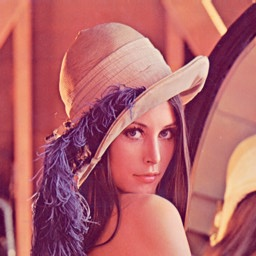

In [39]:
# define quantization tables
qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

qC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

# read an image and show it
url = "http://www.lenna.org/len_std.jpg"
imgOriginal = load_from_url(url)
show(imgOriginal)

#TODO: show different channels

Conversion de l'espace RGB à l'espace luminance/chrominance

In [ ]:
print(imgOriginal[:,:,1])

[[135 135 136 ... 139 144 120]
 [136 136 136 ... 150 151 116]
 [135 135 135 ... 130 122  88]
 ...
 [ 25  30  29 ...  55  62  65]
 [ 25  28  27 ...  64  68  68]
 [ 22  25  26 ...  72  77  77]]


In [27]:
print(imgOriginal)
transform_matrix=np.array([[0.299,0.587,0.114],[-0.1687,-0.3313,0.5],[0.5,-0.4187,-0.0813]]).T
print(transform_matrix)
column_matrix=np.array([0,128,128])

def color_conversion(RGB_matrix):
    """RGB_matrix consists of 3 coefficients of color value
    """
    #Initialization of returned matrix
    YCbCr=np.zeros(np.shape(RGB_matrix))

    YCbCr=np.dot(RGB_matrix,transform_matrix)+column_matrix

    return YCbCr

def image_YCbCr_conversion(img):

    #Initialization of returned image
    YCbCr_img = np.zeros(np.shape(img))

    row,col,par=np.shape(img)
    
    for i in range(row):
        for j in range(col):
            YCbCr_img[i][j]=color_conversion(img[i][j])

    return YCbCr_img

imgYCbCr=image_YCbCr_conversion(imgOriginal)
print(imgYCbCr)
imgY=imgYCbCr[:,:,0]
imgCb=imgYCbCr[:,:,1]
imgCr=imgYCbCr[:,:,2]

[[[225 135 124]
  [225 135 124]
  [226 136 125]
  ...
  [235 139 125]
  [239 144 122]
  [214 120  94]]

 [[225 136 122]
  [225 136 122]
  [225 136 122]
  ...
  [243 150 142]
  [243 151 138]
  [208 116 101]]

 [[227 135 120]
  [227 135 120]
  [227 135 120]
  ...
  [219 130 132]
  [209 122 128]
  [173  88  93]]

 ...

 [[ 89  25  60]
  [ 95  30  64]
  [ 96  29  64]
  ...
  [144  55  75]
  [155  62  80]
  [159  65  81]]

 [[ 86  25  58]
  [ 92  28  62]
  [ 94  27  62]
  ...
  [155  64  81]
  [164  68  80]
  [165  68  79]]

 [[ 83  22  55]
  [ 89  25  59]
  [ 93  26  59]
  ...
  [164  72  87]
  [174  77  88]
  [177  77  87]]]
[[ 0.299  -0.1687  0.5   ]
 [ 0.587  -0.3313 -0.4187]
 [ 0.114   0.5    -0.0813]]
[[[160.656  107.317  173.8943]
  [160.656  107.317  173.8943]
  [161.656  107.317  173.8943]
  ...
  [166.108  104.8048 177.1382]
  [169.897  100.9735 177.2886]
  [145.142   99.1422 177.1138]]

 [[161.015  105.9857 173.6382]
  [161.015  105.9857 173.6382]
  [161.015  105.9857 173.6382]
 

Sous-échantillonage

In [31]:
def matrix_half_reduction(matrix):
    """matrix is a 2D matrix"""
    try:
        row,col=np.shape(matrix)
    except:
        print("There is an error.")
    
    reduced_matrix=np.zeros((row//2,col//2))

    for i in range(0,row,2):
        for j in range(0,col,2):
            reduced_matrix[i//2][j//2]=matrix[i][j]

    return reduced_matrix

matrix=np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]])
print(np.column_stack((matrix,matrix[-1,:])))
print(matrix_half_reduction(matrix))

def img_chrominance_reduction(img):

    try:
        row,col,par=np.shape(img)
    except:
        print("There is an error.")

    Cr_matrix=img[:,:,1]
    Cb_matrix=img[:,:,2]

    Cr_reduced_matrix=matrix_half_reduction(Cr_matrix)
    Cb_reduced_matrix=matrix_half_reduction(Cb_matrix)

    return Cr_reduced_matrix,Cb_reduced_matrix

Cr_matrix,Cb_matrix=img_chrominance_reduction(imgYCbCr)
print(Cr_matrix,Cb_matrix)
    

[[ 1  2  3  4 13]
 [ 5  6  7  8 14]
 [ 9 10 11 12 15]
 [13 14 15 16 16]]
[[ 1.  3.]
 [ 9. 11.]]
[[107.317  107.317  107.317  ... 116.13   108.6361 100.9735]
 [104.9796 104.9796 106.1422 ... 111.13   112.9796 116.3231]
 [102.9735 102.9735 102.9735 ... 112.3048 121.8292 133.0162]
 ...
 [134.8658 133.191  134.8658 ... 131.0223 131.0101 129.004 ]
 [134.7032 134.191  135.8658 ... 130.3475 126.9979 123.9857]
 [134.2093 134.1971 136.0284 ... 129.1727 122.8231 117.8048]] [[173.8943 173.8943 173.8943 ... 177.187  176.9878 177.2886]
 [175.2195 175.2195 175.9756 ... 178.     173.9187 171.0122]
 [176.9634 176.9634 176.9634 ... 175.9187 168.6992 162.1545]
 ...
 [158.0732 160.2358 158.0732 ... 161.061  163.8984 165.6423]
 [157.1545 160.0732 157.9106 ... 163.061  167.3862 170.7114]
 [155.8171 158.6545 158.8293 ... 165.1423 169.9553 175.0244]]


Découpage par bloc

In [36]:
#On travaille seulement sur les niveaux de gris.

def block_splitting_and_centering(matrix):
    """matrix is a 2D matrix"""
    try:
        row,col=np.shape(matrix)
    except:
        print("There is an arror.")
    
    if row%8!=0 or col%8!=0:
        while row%8!=0:
            matrix=np.row_stack((matrix,matrix[-1,:]))
            row=np.shape(matrix)[0]
        while col%8!=0:
            matrix=np.column_stack((matrix,matrix[:,-1]))
            col=np.shape(matrix)[1]
    
    block_matrix=[]

    for i in range(row//8):
        for j in range(col//8):
            block_matrix.append(matrix[i*8:(i+1)*8,j*8:(j+1)*8]-128)

    return block_matrix

Y_block=block_splitting_and_centering(imgY)
Cb_block=block_splitting_and_centering(imgCb)
Cr_block=block_splitting_and_centering(imgCr)
print(block_Y)


[[[[160.656 160.656 161.656 ... 162.015 160.026 158.157]
   [161.015 161.015 161.015 ... 160.026 157.798 157.157]
   [160.798 160.798 160.798 ... 159.097 156.869 154.755]
   ...
   [156.125 156.125 156.125 ... 156.897 157.196 156.196]
   [157.196 156.196 156.196 ... 155.968 155.968 154.968]
   [157.196 157.196 156.196 ... 155.968 154.968 153.968]]

  [[158.043 158.815 157.174 ... 156.114 153.869 155.755]
   [155.815 158.174 156.174 ... 155.114 153.755 155.755]
   [155.114 155.886 154.886 ... 155.125 154.353 155.755]
   ...
   [155.968 156.968 154.854 ... 153.196 151.837 153.125]
   [155.968 156.968 154.968 ... 154.196 152.837 155.125]
   [154.968 156.968 154.968 ... 155.196 153.837 155.897]]

  [[156.043 158.174 161.174 ... 168.636 172.109 174.397]
   [154.815 158.174 161.174 ... 168.821 172.109 173.397]
   [153.815 157.174 159.886 ... 168.821 171.109 172.881]
   ...
   [153.886 156.658 162.256 ... 170.191 170.963 170.952]
   [156.886 159.946 163.658 ... 169.191 168.963 167.952]
   [15

Centrage

In [44]:
transformed_Y = []
transformed_Cr = []
transformed_Cb = []

for e in Y_block:
    transformed_Y.append(cv2.dct(e))
for e in Cr_block:
    transformed_Cr.append(cv2.dct(e))
for e in Cb_block:
    transformed_Cb.append(cv2.dct(e))

print(transformed_Y)

[array([[ 2.40109125e+02,  5.94330946e+00, -4.60511691e+00,
         2.84979011e+00, -4.12375000e-01, -2.65685565e-01,
         5.56641262e-02,  4.06460203e-01],
       [ 1.39957016e+01,  2.20168900e+00, -3.20950203e+00,
         3.75053095e-01,  1.87015699e-01, -4.63286854e-01,
         4.03852729e-01,  1.48367169e-01],
       [ 2.59330023e+00,  7.39305029e-02, -1.86246920e-01,
         1.06801065e-01,  1.50766618e-01,  2.15581828e-01,
        -7.74335364e-02, -1.07174770e-01],
       [ 6.95933142e-01, -4.44751267e+00,  3.59108417e-01,
         5.56279045e-02,  4.65811319e-02,  1.94208561e-01,
        -1.34500448e-01,  5.58447403e-01],
       [ 1.73125000e-01, -4.31012139e-01, -3.72216857e-01,
         2.52424839e-01, -3.04875000e-01, -2.49965664e-01,
         2.18173709e-01, -2.26866901e-01],
       [-5.53567634e-01,  3.29002587e-01,  2.79532010e-01,
        -4.81381566e-02, -2.90306918e-01,  4.27624135e-01,
         3.57879259e-01,  1.54232970e-01],
       [-1.91353986e-01, -2.12007

Quantification

In [45]:
quantized_Y_matrix=[]
quantized_Cb_matrix=[]
quantized_Cr_matrix=[]

for matrix in transformed_Y:
    quantized_Y_matrix.append(np.round(matrix/qY))
for matrix in transformed_Cb:
    quantized_Cb_matrix.append(np.round(matrix/qC))
for matrix in transformed_Cr:
    quantized_Cr_matrix.append(np.round(matrix/qC))
print(quantized_Gray_matrix)

[array([[15.,  1., -0.,  0., -0., -0.,  0.,  0.],
       [ 1.,  0., -0.,  0.,  0., -0.,  0.,  0.],
       [ 0.,  0., -0.,  0.,  0.,  0., -0., -0.],
       [ 0., -0.,  0.,  0.,  0.,  0., -0.,  0.],
       [ 0., -0., -0.,  0., -0., -0.,  0., -0.],
       [-0.,  0.,  0., -0., -0.,  0.,  0.,  0.],
       [-0., -0.,  0.,  0., -0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -0.,  0.,  0.,  0.]]), array([[14.,  1.,  0., -0.,  0., -0., -0., -0.],
       [ 0., -0., -0., -0., -0.,  0.,  0., -0.],
       [ 0., -0., -0.,  0.,  0.,  0.,  0., -0.],
       [-0.,  0.,  0.,  0.,  0., -0.,  0., -0.],
       [-0.,  0., -0., -0., -0., -0., -0., -0.],
       [ 0., -0.,  0., -0.,  0.,  0.,  0.,  0.],
       [ 0., -0., -0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]]), array([[18., -4., -1., -0.,  0., -0., -0.,  0.],
       [-0., -1.,  0., -0.,  0., -0., -0.,  0.],
       [ 0.,  1.,  0., -0.,  0.,  0., -0.,  0.],
       [ 0., -0., -0., -0.,  0.,  0.,  0.,  0.],
       [ 0.,  0

Zigzag

In [63]:
Zigzag_Y=[]
Zigzag_Cb=[]
Zigzag_Cr=[]

for matrix in quantized_Y_matrix:
    Zigzag_Y.append(zigzag(matrix))
for matrix in quantized_Cb_matrix:
    Zigzag_Cb.append(zigzag(matrix))
for matrix in quantized_Cr_matrix:
    Zigzag_Cr.append(zigzag(matrix))
print(Zigzag_Y)

[array([15.,  1.,  1.,  0.,  0., -0.,  0., -0.,  0.,  0.,  0., -0., -0.,
        0., -0., -0.,  0.,  0.,  0., -0., -0., -0.,  0., -0.,  0.,  0.,
       -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.,  0.,  0., -0.,
       -0.,  0., -0.,  0., -0., -0., -0., -0.,  0.,  0.,  0., -0.,  0.,
        0.,  0., -0.,  0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([14.,  1.,  0.,  0., -0.,  0., -0., -0., -0., -0., -0.,  0., -0.,
       -0.,  0., -0., -0.,  0.,  0.,  0.,  0.,  0., -0., -0.,  0.,  0.,
        0., -0., -0.,  0.,  0.,  0., -0.,  0., -0.,  0.,  0., -0., -0.,
       -0., -0.,  0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
       -0., -0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.]), array([18., -4., -0.,  0., -1., -1., -0.,  0.,  1.,  0.,  0., -0.,  0.,
       -0.,  0., -0.,  0., -0., -0.,  0., -0., -0., -0.,  0., -0.,  0.,
       -0., -0.,  0., -0.,  0.,  0., -0.,  0.,  0., -0., -0.,  0.,  0.,
        0.,  0., -0.,  0.,  0.,  0., -0.,  0., -0., -0., -0.,  0.,  0

RLC

In [65]:
rlen_Y=[]
rlen_Cb=[]
rlen_Cr=[]

for l in Zigzag_Y:
    rlen_Y.append(rlencode(l))
for l in Zigzag_Cb:
    rlen_Cb.append(rlencode(l))
for l in Zigzag_Cr:
    rlen_Cr.append(rlencode(l))

rlen_Y

[array([ 15.,   1.,   1., 257.,  61.]),
 array([ 14.,   1., 257.,  62.]),
 array([ 18.,  -4., 257.,   2.,  -1.,  -1., 257.,   2.,   1., 257.,  55.]),
 array([ 10.,  15.,   2., 257.,   2.,  -4.,   1., 257.,  57.]),
 array([-15.,  -3.,   1., 257.,   2.,   1.,   1., 257.,  57.]),
 array([-11., 257.,   1.,   1.,   1.,  -1., 257.,  59.]),
 array([ -9.,  -3.,   1., 257.,   2.,   1., 257.,  58.]),
 array([ -2.,  -2., 257.,  62.]),
 array([  1.,  -1.,   1., 257.,  61.]),
 array([  1., 257.,   3.,  -1., 257.,  59.]),
 array([  3.,  -1., 257.,  62.]),
 array([  2., 257.,  63.]),
 array([  2., 257.,   1.,   1., 257.,  61.]),
 array([  1.,   1.,   1., 257.,  61.]),
 array([  1., 257.,  63.]),
 array([  2.,   1., 257.,  62.]),
 array([  1.,   1.,   1., 257.,   2.,   1., 257.,   1.,   1., 257.,  56.]),
 array([257.,   2.,   1., 257.,  61.]),
 array([257,  64]),
 array([ -6.,   4., 257.,   3.,  -1., 257.,  58.]),
 array([  1., -12.,   4., 257.,   4.,  -2., 257.,   5.,  -1., 257.,  50.]),
 array([ 14.

Huffman encoding

In [71]:
Y_Huffman=[]
Cb_Huffman=[]
Cr_Huffman=[]
Y_encoded=[]
Cb_encoded=[]
Cr_encoded=[]

for l in rlen_Y:
    Y_Huffman.append(construct_huffman_table(l))
for l in rlen_Cb:
    Cb_Huffman.append(construct_huffman_table(l))
for l in rlen_Cr:
    Cr_Huffman.append(construct_huffman_table(l))

for l in Y_Huffman:
    for m in rlen_Y:
        Y_encoded.append(encode_huffman(m,l))
for l in Cb_Huffman:
    for m in rlen_Cb:
        Cb_encoded.append(encode_huffman(m,l))
for l in Cr_Huffman:
    for m in rlen_Cr:
        Cr_encoded.append(encode_huffman(m,l))

KeyError: 14.0

In [ ]:
# For students
# TODO: Write your 'main' code
# convert color image into gray image (or image in YCrCb space)

# This is just an example of coding, you can make your code differently

# ADVICE: create an other 'Code cell' and write/test your code gradually there
# since the code given here is not exectable yet

img = cv2.cvtColor(...)
# color
# First, you can work with only gray images for simplicity


width = len(img[0])
height = len(img)

#
img_gray = np.zeros((height, width), np.float32) + img[:, :, 0]
#

#show img_gray

# define block size

# compute number of blocks

# padding

# luminance channels

# for color images -----
# chrominance channels should be sub-sampled with different sub-sampling factors
# A very simple way: using a 2x2 averaging filter # another type of filter can be used
# then we can work with the sub-sampled version...
#--------------------

# define empty matrices to store Dct
# imgDct

# define empty matrices to store the quantized values
# imgQ


# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])


ZZ_Blk = np.zeros(blockSize * blockSize) #1D

vRLC = []

size_vRLC = 0

#pseudo-code
for i in range('number of block'): #of course, this needs to be computed
    for j in range('number of block'):
        block = y[ ....]). # extract the block

        # dct
        # you can use something like imgDct['index'] = ...

        # quantification
        # you can use something like imgQ['index'] = ...

        # easy ZigZag Version 2:
        ZZ_Blk = ...#
        # zigzag (1D)

        # run length coding (1D)
        # can use `extend` function of numpy vRLC.extend()

#end for


# Huffman
mat_table: dict = construct_huffman_table...
mat_encoded: str = encode_huffman...

In [ ]:
# For testing a block, all steps (notably zigzag, rlc) are OK


**Compute compression rates at different stages**

In [ ]:
# number of bits in original image
H, W, C = img.shape


print(size_yRLC)

**Decodage**

In [ ]:
# Huffman decoding
decoded = decode_huffman...
print(len(decoded))

In [ ]:
print(decoded)

In [ ]:
decoded - yRLC